In [1]:
import sys
sys.path.append("..")
import os
import time
import tempfile
from collections import defaultdict
RASTERIO_BEST_PRACTICES = dict(
    CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
    AWS_NO_SIGN_REQUEST="YES",
    GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
    GDAL_SWATH_SIZE="200000000",
    VSI_CURL_CACHE_SIZE="200000000",
)
os.environ.update(RASTERIO_BEST_PRACTICES)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import rasterio
import rasterio.warp
import rasterio.mask
import shapely.geometry

from NAIPTileIndex import NAIPTileIndex
from models import RCF, featurize

In [2]:
device = torch.device('cuda')

## Initialize model

In [3]:
num_features = 1024

model = RCF(num_features).eval().to(device)

## Read data

In [5]:
df = pd.read_csv("../data/outcomes_sampled_population_CONTUS_16_640_POP_100000_0.csv", index_col=0)
points = df[["lon", "lat"]].values
y_all = df["population"].values

## Extract features method 1

In [6]:
index = NAIPTileIndex("../tmp/")

In [9]:
buffer_distance = 250  # in meters
x_all_new = np.zeros((points.shape[0], num_features), dtype=float)

tic = time.time()
for i, (lon, lat) in enumerate(points):
    
    if i % 100 == 0:
        print(f"{i}/{points.shape[0]} -- {i / points.shape[0] * 100:0.2f} -- {time.time()-tic:0.2f} seconds")
        tic = time.time()
    
    if i % 200 == 0 and i > 0:
        break
    
    point_geom = shapely.geometry.mapping(
        shapely.geometry.Point(lon, lat)
    )
    
    fns = list(set(index.lookup_point(lat, lon)))
    fns = sorted(fns, key=lambda x: int(x.split("/")[6])) # sort by year
    
    fn = fns[-1]    
    
    with rasterio.open(fn, "r") as f:
        point_geom = rasterio.warp.transform_geom("epsg:4326", f.crs.to_string(), point_geom)
        point_shape = shapely.geometry.shape(point_geom)
        
        mask_shape = point_shape.buffer(buffer_distance).envelope
        mask_geom = shapely.geometry.mapping(mask_shape)
        
        out_image, out_transform = rasterio.mask.mask(f, [mask_geom], crop=True)
        
    features = featurize(out_image, model, device)
    x_all_new[i] = features

0/100000 -- 0.00 -- 0.00 seconds
100/100000 -- 0.10 -- 27.89 seconds
200/100000 -- 0.20 -- 27.52 seconds


## Extract features method 2

In [7]:
class CustomDataset(Dataset):

    def __init__(self, points, fns, buffer=250):
        self.points = points
        self.fns = fns
        self.buffer = buffer

    def __len__(self):
        return self.points.shape[0]

    def __getitem__(self, idx):
        
        lon, lat = self.points[idx]
        fn = self.fns[idx]
        
        point_geom = shapely.geometry.mapping(
            shapely.geometry.Point(lon, lat)
        )
        
        with rasterio.Env():
            with rasterio.open(fn, "r") as f:
                point_geom = rasterio.warp.transform_geom("epsg:4326", f.crs.to_string(), point_geom)
                point_shape = shapely.geometry.shape(point_geom)
                mask_shape = point_shape.buffer(self.buffer).envelope
                mask_geom = shapely.geometry.mapping(mask_shape)
                out_image, out_transform = rasterio.mask.mask(f, [mask_geom], crop=True)
        
        out_image = (out_image / 255.0)
        out_image = torch.from_numpy(out_image).float()
        return out_image

In [10]:
%%time
index = NAIPTileIndex("../tmp/")
all_fns = []
for i, (lon, lat) in enumerate(points):
    point_geom = shapely.geometry.mapping(
        shapely.geometry.Point(lon, lat)
    )
    
    fns = list(set(index.lookup_point(lat, lon)))
    fns = sorted(fns, key=lambda x: int(x.split("/")[6])) # sort by year
    fn = fns[-1]    
    all_fns.append(fn)

CPU times: user 35.3 s, sys: 1.48 s, total: 36.8 s
Wall time: 36.8 s


In [11]:
buffer_distance = 250  # in meters
dataset = CustomDataset(points, all_fns, buffer=buffer_distance)

dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=False,
    num_workers=8,
    collate_fn=lambda x: x,
    pin_memory=False
)

In [12]:
x_all = np.zeros((points.shape[0], num_features), dtype=float)

tic = time.time()
i = 0
for images in dataloader: 
    for image in images:
        
        if image.shape[0] == 4:
            image = image.to(device)
            with torch.no_grad():
                feats = model(image.unsqueeze(0)).cpu().numpy() 
        
            x_all[i] = feats
        elif image.shape[0] == 3:
            pass # this happens in at least Nevada for some points
        
        if i % 1000 == 0:
            print(f"{i}/{points.shape[0]} -- {i / points.shape[0] * 100:0.2f} -- {time.time()-tic:0.2f} seconds")
            tic = time.time()
        i += 1

0/100000 -- 0.00 -- 3.24 seconds
1000/100000 -- 1.00 -- 35.26 seconds
2000/100000 -- 2.00 -- 38.30 seconds
3000/100000 -- 3.00 -- 33.66 seconds
4000/100000 -- 4.00 -- 33.62 seconds
5000/100000 -- 5.00 -- 35.95 seconds
6000/100000 -- 6.00 -- 35.55 seconds
7000/100000 -- 7.00 -- 34.08 seconds
8000/100000 -- 8.00 -- 37.05 seconds
9000/100000 -- 9.00 -- 36.71 seconds
10000/100000 -- 10.00 -- 34.99 seconds
11000/100000 -- 11.00 -- 34.63 seconds
12000/100000 -- 12.00 -- 35.59 seconds
13000/100000 -- 13.00 -- 34.51 seconds
14000/100000 -- 14.00 -- 35.02 seconds
15000/100000 -- 15.00 -- 35.08 seconds
16000/100000 -- 16.00 -- 34.28 seconds
17000/100000 -- 17.00 -- 35.62 seconds
18000/100000 -- 18.00 -- 34.31 seconds
19000/100000 -- 19.00 -- 34.37 seconds
20000/100000 -- 20.00 -- 35.91 seconds
21000/100000 -- 21.00 -- 34.30 seconds
22000/100000 -- 22.00 -- 33.94 seconds
23000/100000 -- 23.00 -- 34.59 seconds
24000/100000 -- 24.00 -- 33.82 seconds
25000/100000 -- 25.00 -- 34.82 seconds
26000/1000

In [13]:
x_all.shape

(100000, 1024)

In [14]:
y_all.shape

(100000,)

In [15]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=0)

In [17]:
ridge_cv = RidgeCV(cv=5, alphas = np.logspace(-8,8,base=10,num=17))
ridge_cv.fit(x_train, y_train)

/anaconda/envs/torchgeo/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.72023e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/anaconda/envs/torchgeo/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.80552e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/anaconda/envs/torchgeo/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.85765e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/anaconda/envs/torchgeo/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.49918e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/anaconda/envs/torchgeo/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (r

RidgeCV(alphas=array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08]),
        cv=5)

In [18]:
ridge_cv.best_score_

0.45673052321015195

In [19]:
y_pred = np.maximum(ridge_cv.predict(x_test), 0)

In [20]:
r2_score(y_test, y_pred)

0.4974736845711334

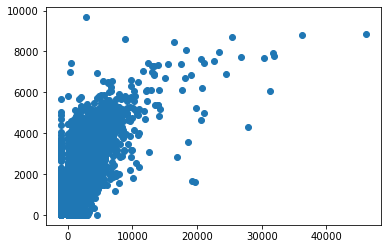

In [21]:
plt.figure()
plt.scatter(y_test, y_pred)
plt.show()
plt.close()